In [86]:
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="husl", style="whitegrid")

In [28]:
df = pd.read_csv("./dataset/test.csv", index_col=0, parse_dates=[0])
baseline = df.sum(axis=1).pct_change().fillna(0)

# RL

In [50]:
def get_results(model):
    df = pd.read_csv(f"./results/{model}.csv", index_col=0)[:-6]
    df.index = baseline.index

    plt.plot((1+df).cumprod()-1)
    plt.title(f"{str.upper(model)} Performaces")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")

    return df
    

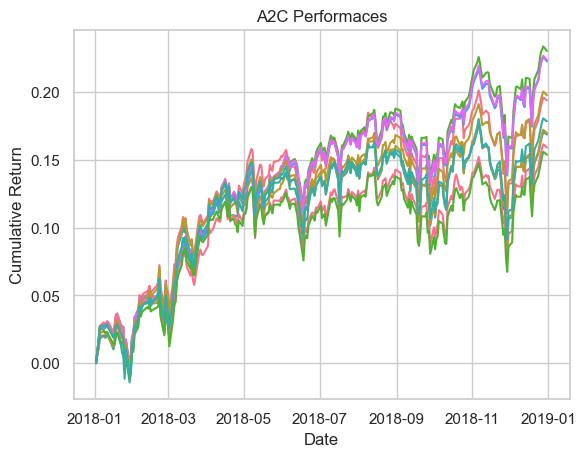

In [51]:
a = get_results('a2c')

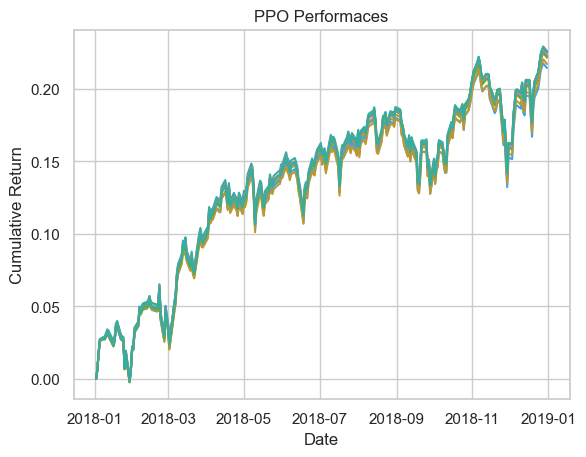

In [52]:
p = get_results('ppo')

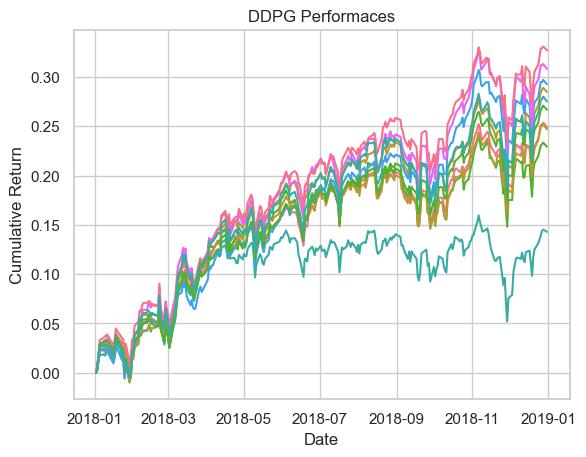

In [53]:
d = get_results('ddpg')

# Comparison

In [ ]:
import yfinance as yf
sp500 = yf.Ticker("^GSPC").history(start="2018-01-01", end="2019-01-01")

Text(0, 0.5, 'Cumulative Return')

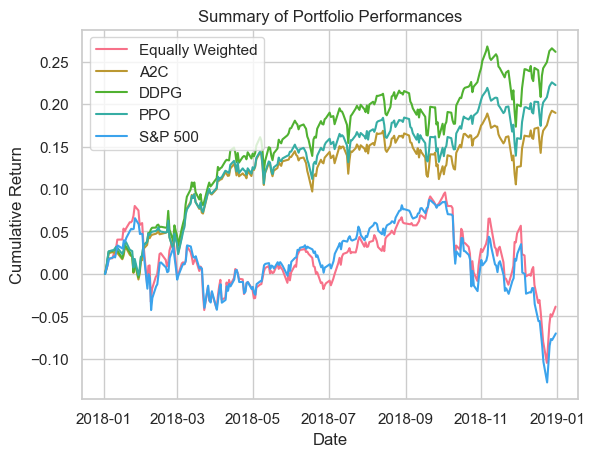

In [69]:
plt.plot( (1+baseline).cumprod()-1, label="Equally Weighted")
plt.plot( (1+a.mean(axis=1)).cumprod()-1, label="A2C")
plt.plot( (1+d.mean(axis=1)).cumprod()-1, label="DDPG")
plt.plot( (1+p.mean(axis=1)).cumprod()-1, label="PPO")
plt.plot( (1+sp500["Close"].pct_change().fillna(0)).cumprod()-1, label="S&P 500")
plt.legend()
plt.title("Summary of Portfolio Performances")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")

# Backtest

In [149]:
class Analysis:
    """
    Backtest portfolio performance
    Input:
    --------
    A series of dataframe
    """

    def __init__(self, df, save=False):
        self.pct = df
        self.netvalue = self.pct.add(1).cumprod()
        self.save = save

    # 累积收益率
    def calculate_return(self):
        total_return = self.netvalue.iloc[-1] - 1
        return total_return

    # 年化收益率
    def calculate_annualreturn(self):        
        annual_return = self.pct.mean()*252
        return annual_return

    # 最大回撤
    def calculate_mdd(self):
        drawdown = 1 - self.netvalue.div(self.netvalue.cummax())
        mdd = drawdown.max()
        return mdd

    # 年化波动率
    def calculate_volatility(self):
        monthly_std = self.pct.std()
        annual_std = monthly_std * np.sqrt(252)
        return annual_std

    # 信息比率 -- 有点问题


    def report(self):
        df = pd.DataFrame()
        df["Cumulative Return"] = [self.calculate_return()]
        df["Annualized Return"] = self.calculate_annualreturn()
        df["Annualized Volatility"] = self.calculate_volatility()
        df["MDD"] = self.calculate_mdd()
        df = df.applymap(lambda x: "{:.2f}%".format(x*100))
        df["Sharpe"] =  self.calculate_annualreturn() / self.calculate_volatility()
        df.iloc[:, -1] = df.iloc[:, -1].apply(lambda x: "{:.3f}".format(x))
        if self.save:
            df.to_csv("{}-结果统计.csv".format(self.name), encoding="utf-8")
        else:
            pass            
        
        return df

In [158]:
sp500["Close"].pct_change().fillna(0)

Date
2018-01-02 00:00:00-05:00    0.000000
2018-01-03 00:00:00-05:00    0.006399
2018-01-04 00:00:00-05:00    0.004029
2018-01-05 00:00:00-05:00    0.007034
2018-01-08 00:00:00-05:00    0.001662
                               ...   
2018-12-24 00:00:00-05:00   -0.027112
2018-12-26 00:00:00-05:00    0.049594
2018-12-27 00:00:00-05:00    0.008563
2018-12-28 00:00:00-05:00   -0.001242
2018-12-31 00:00:00-05:00    0.008492
Name: Close, Length: 251, dtype: float64

In [159]:
Analysis( sp500["Close"].pct_change().fillna(0) ).report()

,Cumulative Return,Annualized Return,Annualized Volatility,MDD,Sharpe
0,-7.01%,-5.85%,17.03%,19.78%,-0.343


In [151]:
Analysis(baseline).report()

,Cumulative Return,Annualized Return,Annualized Volatility,MDD,Sharpe
0,-3.85%,-2.30%,18.14%,18.32%,-0.127


In [142]:
res = []
res.append( Analysis(a.mean(axis=1)).report() )
res.append( Analysis(d.mean(axis=1)).report() )
res.append( Analysis(p.mean(axis=1)).report() )
res.append( Analysis(baseline).report() )

In [161]:
res.append(Analysis( sp500["Close"].pct_change().fillna(0) ).report())

In [162]:
res_df = pd.concat(res, axis=0)
res_df["Model"] = ["A2C", "DDPG", "PPO", "Baseline", "S&P500"]

In [163]:
res_df

,Cumulative Return,Annualized Return,Annualized Volatility,MDD,Sharpe,Model
0,18.97%,18.20%,12.26%,7.03%,1.484,A2C
0,26.17%,24.19%,13.04%,7.46%,1.855,DDPG
0,22.25%,20.91%,12.09%,6.56%,1.730,PPO
0,-3.85%,-2.30%,18.14%,18.32%,-0.127,Baseline
0,-7.01%,-5.85%,17.03%,19.78%,-0.343,S&P500
